# Label-free classification using IDEAS features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scip_workflows.common import *


In [3]:
import fcsparser
import seaborn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
from scip_workflows import core


In [4]:
plt.rcParams["figure.dpi"] = 200


# Data

In [10]:
try:
    features = snakemake.input.features
    labels = snakemake.input.labels
    hpo_cyto = snakemake.input.hpo_cyto
    output_confmat = snakemake.output.confmat
    output_metrics = snakemake.output.metrics
except NameError:
    data_dir = Path("/home/maximl/scratch/data/vsc/datasets/wbc/ideas/")
    features = data_dir / "WBC_features.parquet"
    labels = data_dir / "labels.parquet"
    hpo_cyto = data_dir / "hpo" / "WBC_rsh_ideas_cyto_li_xgboost.pickle"
    hpo_full = data_dir / "hpo" / "WBC_rsh+innersample_ideas_full_li_xgboost.pickle"
    output_confmat = data_dir / "figures" / "WBC_ideas_cv_confmat.png"
    output_metrics = data_dir / "figures" / "WBC_ideas_cv_metrics.png"


In [6]:
df = pq.read_table(features).to_pandas()
labels = pq.read_table(labels).to_pandas()
df = df.merge(labels, left_index=True, right_index=True)


In [7]:
r = r"(?i).*(uncompensated|bkgd|saturation|\().*"
todrop = list(filter(lambda x: re.match(r, x), df.columns))
df = df.drop(columns=todrop)
df.shape


(274050, 306)

In [13]:
df = df.loc[df["meta_label"] != "unknown"].copy()
df["meta_label"] = df["meta_label"].astype("category")
enc = LabelEncoder().fit(df["meta_label"])

# HPO results

In [ ]:
with open(hpo_cyto, "rb") as fh:
    grid = pickle.load(fh)


In [ ]:
grid["test_balanced_accuracy"].mean(), scipy.stats.sem(grid["test_balanced_accuracy"])


In [ ]:
grid["test_balanced_accuracy"], grid["train_balanced_accuracy"]


In [11]:
with open(hpo_full, "rb") as fh:
    grid = pickle.load(fh)


[12:04:23] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


In [12]:
grid["test_balanced_accuracy"], grid["train_balanced_accuracy"]


(array([0.64687405]), array([0.91173298]))

# Classification

In [ ]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])


In [ ]:
X = (
    df.filter(regex="(bf420nm480nm|bf570nm595nm|m01|m06|m09|ssc)$")
    .drop(2, level="meta_group")
    .drop("late", level="meta_fix")
)

y = enc.transform(
    df.drop(2, level="meta_group").drop("late", level="meta_fix")["meta_label"]
)
preds = []
true = []

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for estimator, (_, test_index) in zip(grid["estimator"], skf.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true,
    preds,
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize="true",
    xticks_rotation="vertical",
    values_format=".2f",
    ax=ax,
)
plt.savefig(output_confmat, bbox_inches="tight")


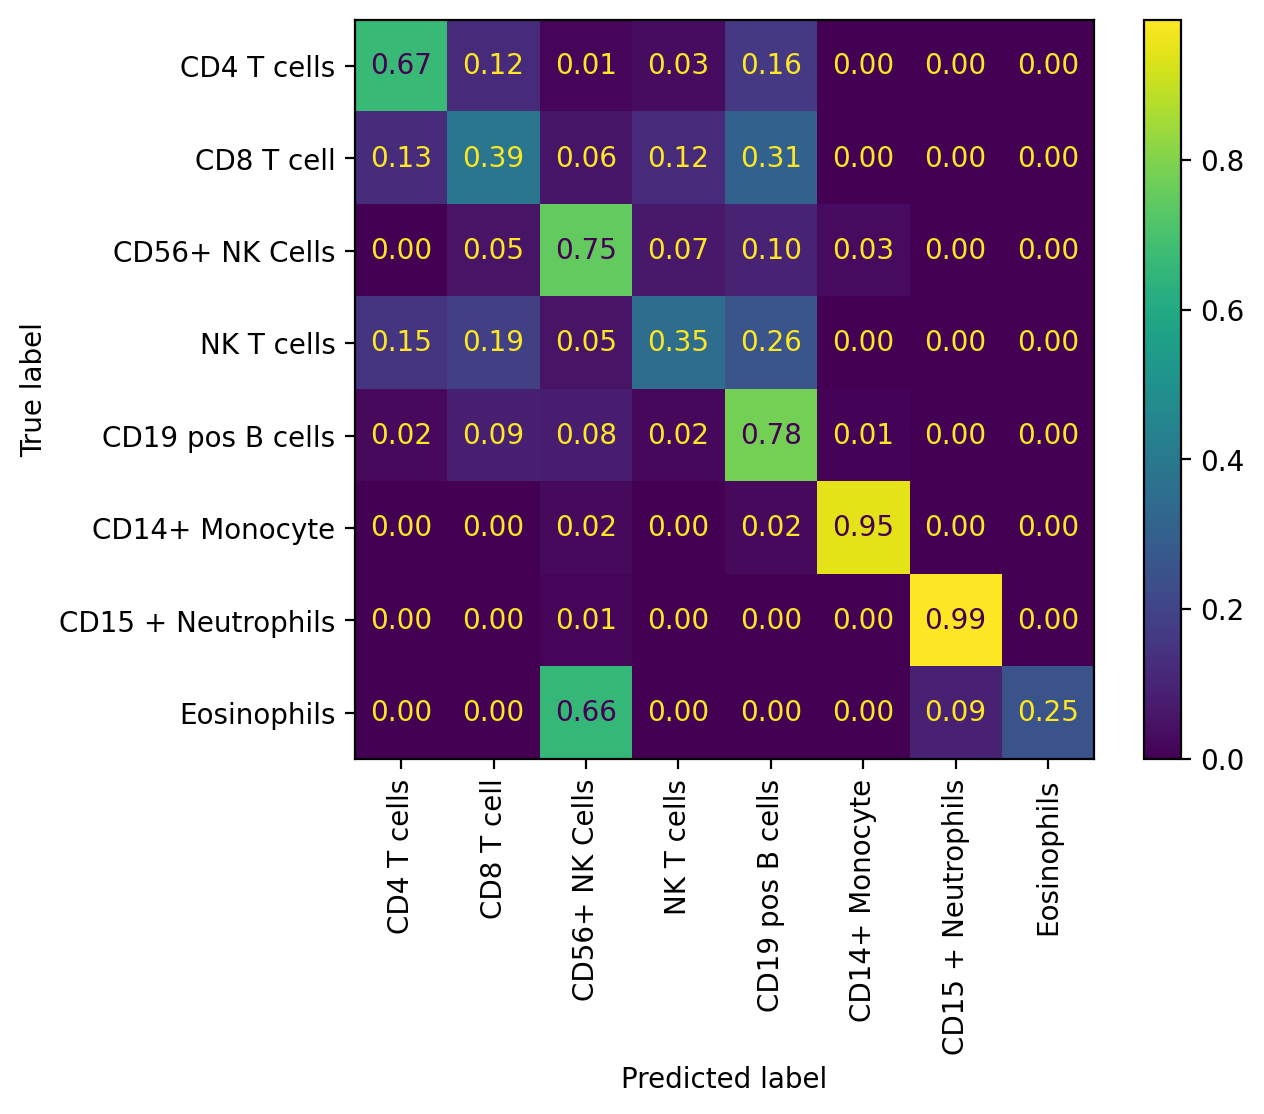

In [14]:
from sklearn.model_selection import PredefinedSplit

X = df.filter(regex="(bf420nm480nm|bf570nm595nm|m01|m06|m09|ssc)$")
y = enc.transform(df["meta_label"])
preds = []
true = []

test_fold_outer = df.index.to_frame().apply(
    lambda x: 0 if (x["meta_group"] == 2) and (x["meta_fix"] == "early") else -1,
    axis="columns"
).values 
outer_cv = PredefinedSplit(test_fold_outer)
for estimator, (_, test_index) in zip(grid["estimator"], outer_cv.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true,
    preds,
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize="true",
    xticks_rotation="vertical",
    values_format=".2f",
    ax=ax,
)
plt.savefig(output_confmat, bbox_inches="tight")
